### a ytBaseModel pydantic class experiment

this notebook subclasses pydantic's `BaseModel` class to create an abstract `ytBaseModel` class that includes some business for executing the corresponding methods. 

The `ytBaseModel` class:
* uses the `inspect.getfullargspec` within `ytBaseModel._run()` to retrieve the expected argument order of the yt method and then calls the yt method using the values in the `ytBaseModel` attributes.
* checks if any of args being passed to the yt call are themselves `ytBaseModel` instances, in which case `ytBaseModel._run()` gets called for that argument.
* uses a protected dictionary attribute, `_arg_mapping`, to map any argument names we have changed betwen yt's internal calls and the pydantic class. `_args_mapping['yt_name'] -> 'schema_name'`.

So here's the base class:

In [1]:
from pydantic import BaseModel
from inspect import getfullargspec


class ytBaseModel(BaseModel):
    _arg_mapping: dict = {}  # mapping from internal yt name to schema name

    def _run(self):
        # this method actually executes the yt code 
        
        # first make sure yt is imported and then get our function handle. This assumes
        # that our class name exists in yt's top level api.
        import yt
        func = getattr(yt, type(self).__name__)
        print(f"pulled func {func}")

        # now we get the arguments for the function:
        # func_spec.args, which lists the named arguments and keyword arguments.
        # ignoring vargs and kw-only args for now...
        # see https://docs.python.org/3/library/inspect.html#inspect.getfullargspec
        func_spec = getfullargspec(func)

        # the list that we'll use to eventually call our function
        the_args = []

        # the argument position number at which we have default values (a little hacky, should
        # be a better way to do this, and not sure how to scale it to include *args and **kwargs)
        n_args = len(func_spec.args)  # number of arguments
        if func_spec.defaults is None:
            # no default args, make sure we never get there...
            named_kw_start_at = n_args + 1
        else:
            # the position at which named keyword args start
            named_kw_start_at = n_args - len(func_spec.defaults)
        print(f"keywords start at {named_kw_start_at}")

        # loop over the call signature arguments and pull out values from our pydantic class .
        # this is recursive! will call _run() if a given argument value is also a ytBaseModel.
        for arg_i, arg in enumerate(func_spec.args):
            # check if we've remapped the yt internal argument name for the schema
            if arg in self._arg_mapping:
                arg = self._arg_mapping[arg]

            # get the value for this argument. If it's not there, attempt to set default values 
            # for arguments needed for yt but not exposed in our pydantic class
            try:
                arg_value = getattr(self, arg)
            except AttributeError:
                if arg_i >= named_kw_start_at:
                    # we are in the named keyword arguments, grab the default
                    # the func_spec.defaults tuple 0 index is the first named
                    # argument, so need to offset the arg_i counter
                    default_index = arg_i - named_kw_start_at
                    arg_value = func_spec.defaults[default_index]
                else:
                    raise AttributeError

            # check if this argument is itself a ytBaseModel for which we need to run
            # this should make this a fully recursive function?
            # if hasattr(arg_value,'_run'):
            if isinstance(arg_value, ytBaseModel):
                print(f"{arg_value} is a ytBaseModel, calling {arg_value}._run() now...")
                arg_value = arg_value._run()

            the_args.append(arg_value)
        print(the_args)
        return func(*the_args)

Now we'll create two new classes for `load` and `SlicePlot`:

In [2]:
class load(ytBaseModel):
    filename: str
    _arg_mapping: dict = {"fn": "filename"}

class SlicePlot(ytBaseModel):
    ds: load = None
    normal: str = 'x'
    field: tuple = ('all', 'Density')
    _arg_mapping: dict = {"fields": "field"}

now let's instantiate some classes:

In [3]:
ds = load(filename='snapshot_033')
slc = SlicePlot(ds=ds, dim='x',field=("PartType0","Density"))

so these objects are normal pydantic classes:

In [4]:
ds.schema()

{'title': 'load',
 'type': 'object',
 'properties': {'filename': {'title': 'Filename', 'type': 'string'}},
 'required': ['filename']}

In [5]:
slc.schema()

{'title': 'SlicePlot',
 'type': 'object',
 'properties': {'ds': {'$ref': '#/definitions/load'},
  'normal': {'title': 'Normal', 'default': 'x', 'type': 'string'},
  'field': {'title': 'Field',
   'default': ('all', 'Density'),
   'type': 'array',
   'items': {}}},
 'definitions': {'load': {'title': 'load',
   'type': 'object',
   'properties': {'filename': {'title': 'Filename', 'type': 'string'}},
   'required': ['filename']}}}

but now we can use .run() to execute!

/home/chavlin/src/yt/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/chavlin/.config/yt/ytrc is deprecated in favor of /home/chavlin/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0 . This feature will be removed in v4.1.0
  from yt.config import ytcfg
yt : [INFO     ] 2021-03-05 12:49:08,648 Parameters: current_time              = 4.343952725460923e+17 s
yt : [INFO     ] 2021-03-05 12:49:08,648 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-03-05 12:49:08,648 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-03-05 12:49:08,649 Parameters: domain_right_edge         = [25. 25. 25.]
yt : [INFO     ] 2021-03-05 12:49:08,649 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-03-05 12:49:08,649 Parameters: current_redshift          = -4.811891664902035e-05
yt : [INFO     ] 2021-03-05 12:49:08,650 Parameters: o

pulled func <function SlicePlot at 0x7f0502614430>
keywords start at 1
filename='snapshot_033' is a ytBaseModel, calling filename='snapshot_033'._run() now...
pulled func <function load at 0x7f05058b35e0>
keywords start at 2
['snapshot_033']
[snap_033, 'x', ('PartType0', 'Density'), None]



yt : [INFO     ] 2021-03-05 12:49:12,592 xlim = 0.000000 25.000000
yt : [INFO     ] 2021-03-05 12:49:12,592 ylim = 0.000000 25.000000
yt : [INFO     ] 2021-03-05 12:49:12,593 xlim = 0.000000 25.000000
yt : [INFO     ] 2021-03-05 12:49:12,593 ylim = 0.000000 25.000000
yt : [INFO     ] 2021-03-05 12:49:12,599 Making a fixed resolution buffer of (('PartType0', 'Density')) 800 by 800



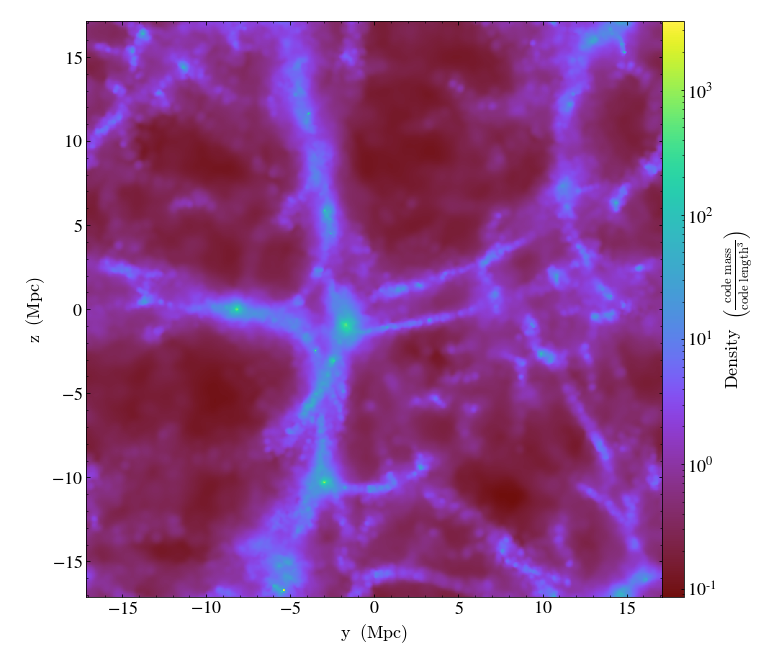

In [6]:
slc._run()